In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm

from math import *

In [4]:
def HeMC (S0, r, v0, rho, kappa, theta, xi, T, dt):

    # Generate 1 Monte Carlo simulation for the Heston model

    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W   = np.random.multivariate_normal(MU, COV, T)
    W_S = W[:,0]
    W_v = W[:,1]

    # Generate paths
    vt    = np.zeros(T)
    vt[0] = v0
    St    = np.zeros(T)
    St[0] = S0
    for t in range(1,T):
        vt[t] = np.abs(vt[t-1] + kappa*(theta-np.abs(vt[t-1]))*dt + xi*np.sqrt(np.abs(vt[t-1]))*np.sqrt(dt)*W_v[t])
        St[t] = St[t-1]*np.exp((r - 0.5*vt[t-1])*dt + np.sqrt(vt[t-1]*dt)*W_S[t])

    return St, vt

In [10]:
sqrt(0.02)

0.1414213562373095

In [11]:
T     = 252
dt    = 1/252 # 
S0    = 100 # Initial price
rho   = -0.7 # Correlation
kappa = 1 # Revert rate
theta = 0.04 # Long-term volatility
xi    = 0.2 # Volatility of instantaneous volatility
v0    = 0.02 # Initial instantaneous volatility
r = 0.05

In [12]:
St,vt = HeMC(S0, r, v0, rho, kappa, theta, xi, T, dt)

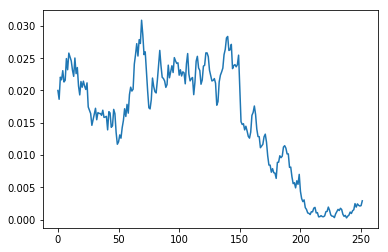

In [13]:
plt.plot(vt)

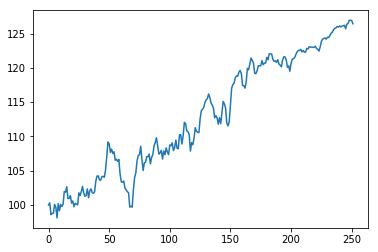

In [14]:
plt.plot(St)

In [15]:
def HeMC_paths(S0, r, v0, rho, kappa, theta, xi, T, dt, nb_scenarios):

    # Generate N Monte Carlo simulation for the Heston model
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    
    simulation_df = pd.DataFrame()
    for scenarioNumber in range(nb_scenarios):
        # Generate random Brownian Motion
        W   = np.random.multivariate_normal(MU, COV, T)
        W_S = W[:,0]
        W_v = W[:,1]
        # Generate paths
        vt    = np.zeros(T)
        vt[0] = v0
        St    = np.zeros(T)
        St[0] = S0

        for t in range(1,T):
            vt[t] = np.abs(vt[t-1] + kappa*(theta-np.abs(vt[t-1]))*dt + xi*np.sqrt(np.abs(vt[t-1]))*np.sqrt(dt)*W_v[t])
            St[t] = St[t-1]*np.exp((r - 0.5*vt[t-1])*dt + np.sqrt(vt[t-1]*dt)*W_S[t])
        simulation_df[scenarioNumber] = St

    return simulation_df

In [16]:

def CalculatePrice(strike, r,T,df_prices_per_scenario, nb_sims):
    pay_offs = 0
    total_scenarios = nb_sims
    df_prices_per_scenario_mat = df_prices_per_scenario.loc[:T]
    for i in range(total_scenarios):
        price = df_prices_per_scenario_mat[i].values.tolist()[-1]
        pay_off = price - strike
        if(pay_off>0): 
            pay_offs=pay_offs+pay_off

    discounted_price = (np.exp(-r * (T/365))*pay_offs)
    result = discounted_price/total_scenarios
    return result
    
    

In [17]:
def plot_scenario_paths(df_prices_per_scenario, nb_scenarios, timestep):
    plt.figure(figsize=(14,8))
    for i in range(nb_scenarios):            
        plt.plot((df_prices_per_scenario.index)*timestep, df_prices_per_scenario[i])            

    plt.ylabel('Stock Value')
    plt.xlabel('Timestep')
    plt.show()

In [18]:
n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if cp_flag == 'c':
        price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
    else:
        price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    return S * sqrt(T)*n(d1)

In [19]:
def find_imp_vol(target_value, S, K, T, r, call_put="c"):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = target_value - price  # our root

        #print(i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [20]:
def read_data(date,index="SPY",indicator="impliedV"):
    path = os.path.join("data",indicator,index,date+"_"+index+"~market__"+indicator+".csv")
    df = pd.read_csv(path)
    return(df)

In [21]:
def get_iv_atm(expiry,df):
    df1 = df[df.expiry == expiry]
    df_bis = df1.drop_duplicates("expiry")
    df_bis["strike"] = df_bis["fwd"]
    df_bis["midImpliedV"] = np.nan
    df1 = df1.append(df_bis,ignore_index=True)
    df1.sort_values("strike",inplace=True)
    df1["midImpliedV"] = df1["midImpliedV"].interpolate()
    return(df1[df1["strike"] == df1["fwd"]]["midImpliedV"].values[0])

In [22]:
def add_iv_atm_col(df):
    def change_iv_atm(r,expiry,v):
        if r["expiry"]==expiry:
            r["IV_ATM"]=v
        return r
    # compute of IV_ATM of each expiry and add it to the column df["IV_ATM"]
    df["IV_ATM"] = np.nan
    for expiry in df.expiry.unique():
        v = get_iv_atm(expiry,df)
        df = df.apply(lambda r: change_iv_atm(r,expiry,v), axis=1)
    return df


In [23]:
df_iv = read_data("20180108")
df_iv["expiry"] = df_iv["expiry"].astype("str")
df_iv["expiry"] = pd.to_datetime(df_iv["expiry"],format="%Y-%m-%d")

In [24]:
df_iv = add_iv_atm_col(df_iv)
df_iv["Moneyness"] = np.log(df_iv["strike"]/df_iv["fwd"])/(np.sqrt(df_iv["tenor"])*df_iv["IV_ATM"])

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
df_iv_groupBy = df_iv.groupby(["tenor","strike","expiry"]).mean()
df_iv_groupBy.reset_index("expiry",inplace=True)

In [26]:
df_iv_groupBy.head()

expiry  cleanExpiry    vTenor        spot         fwd  \
tenor    strike                                                             
0.005451 265.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         266.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         266.5  2018-01-10     20180110  0.005815  273.972444  273.934799   
         267.0  2018-01-10     20180110  0.005815  273.972444  273.934799   
         267.5  2018-01-10     20180110  0.005815  273.972444  273.934799   

                 pcIndicator  volume  openInterest  bidPrice  offerPrice  \
tenor    strike                                                            
0.005451 265.5          -1.0   101.0        1136.0      0.01        0.02   
         266.0          -1.0    10.0        2708.0      0.01        0.02   
         266.5          -1.0    50.0        5670.0      0.01        0.02   
         267.0          -1.0   354.0        4730.0      0.01        0.02   
         267.5          -1.0   316.0        6800.0      0.01        0.02   

                 midPrice  bidImpliedV  offerImpliedV  midImpliedV  \
tenor    strike                                                      
0.005451 265.5      0.015     0.171806       0.188126     0.180908   
         266.0      0.015     0.162738       0.178330     0.171419   
         266.5      0.015     0.153594       0.168488     0.161871   
         267.0      0.015     0.144338       0.158635     0.152265   
         267.5      0.015     0.135104       0.148615     0.142643   

                 criticalSpot    IV_ATM  Moneyness  
tenor    strike                                     
0.005451 265.5           -1.0  0.061269  -6.913917  
         266.0           -1.0  0.061269  -6.497987  
         266.5           -1.0  0.061269  -6.082839  
         267.0           -1.0  0.061269  -5.668468  
         267.5           -1.0  0.061269  -5.254873

In [28]:
def compute_iv_Heston_fixedDate(df_iv_groupBy, index_dic_param = 2, tenor_min=0,tenor_max = 1):
    tenor_list_unique = sorted(df_iv_groupBy.index.get_level_values(0).unique())
    df_iv_groupBy["iv_rough_vol_"+str(index_dic_param)] = np.nan
    theta = 0.029416
    kappa = 3.391330 
    sigma = 1.752326 
    rho = -0.623504 
    v0 = 0.004728

    r = 0.05
    S0 = df_iv_groupBy["spot"].values[0]
    print("spot :",S0)
    T_max = 252
    dt = 1/252
    nb_scenarios = 10000
    simulation_df = HeMC_paths(S0, r, v0, rho, kappa, theta, sigma, T_max, dt, nb_scenarios)
    plot_scenario_paths(simulation_df, nb_scenarios, dt)
    for tenor in tenor_list_unique:
        if (tenor>=tenor_min) and (tenor<=tenor_max):
            strike_list = df_iv_groupBy.loc[tenor].index
            for strike in strike_list:
                maturity_days = int(tenor*365)+1
                print("maturity in days : "+str(maturity_days)+" , strike : "+str(strike))
                
                option_price = CalculatePrice(strike,r,maturity_days,simulation_df,nb_scenarios)
                mat_year = maturity_days/365
                iv = find_imp_vol(option_price,S0,strike,mat_year,r)
                print("option price with Monte carlo method : ",option_price)
                print("implied vol with BS formula inversion : ",iv)
                df_iv_groupBy.loc[(tenor,strike),"iv_rough_vol_"+str(index_dic_param)] = iv
        elif tenor>=tenor_max:
            break;
    return df_iv_groupBy

spot : 273.97244356448954


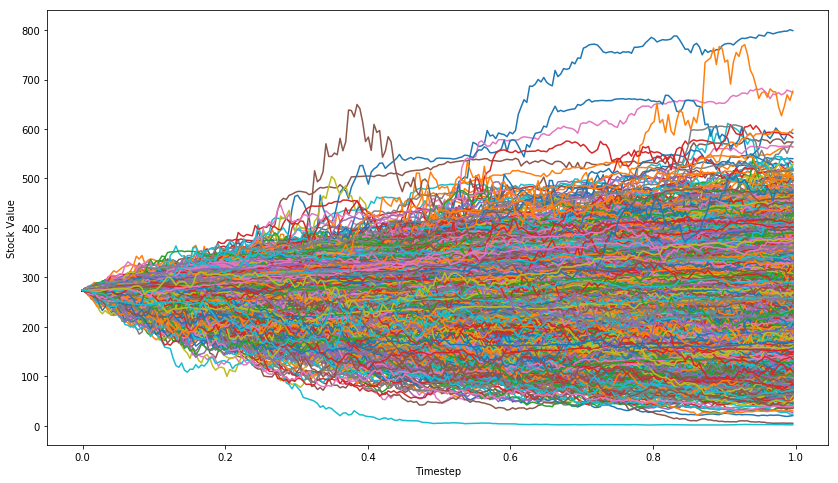

maturity in days : 2 , strike : 265.5
option price with Monte carlo method :  8.573964870510093
implied vol with BS formula inversion :  0.20657806726678432
maturity in days : 2 , strike : 266.0
option price with Monte carlo method :  8.074259156515717
implied vol with BS formula inversion :  0.1962483452591707
maturity in days : 2 , strike : 266.5
option price with Monte carlo method :  7.574729088504253
implied vol with BS formula inversion :  0.18602335217934945
maturity in days : 2 , strike : 267.0
option price with Monte carlo method :  7.075618235985899
implied vol with BS formula inversion :  0.17609596053646065
maturity in days : 2 , strike : 267.5
option price with Monte carlo method :  6.576884086237544
implied vol with BS formula inversion :  0.16635162030891165
maturity in days : 2 , strike : 268.0
option price with Monte carlo method :  6.078828491622816
implied vol with BS formula inversion :  0.15695373620842498
maturity in days : 2 , strike : 268.5
option price with Mon

option price with Monte carlo method :  0.43892322277251805
implied vol with BS formula inversion :  0.09927314541981228
maturity in days : 4 , strike : 277.0
option price with Monte carlo method :  0.23374058912700815
implied vol with BS formula inversion :  0.09890430045075771
maturity in days : 4 , strike : 277.5
option price with Monte carlo method :  0.16808121956831132
implied vol with BS formula inversion :  0.0992878049152285
maturity in days : 4 , strike : 278.0
option price with Monte carlo method :  0.11991008155836043
implied vol with BS formula inversion :  0.09992556909060031
maturity in days : 4 , strike : 279.0
option price with Monte carlo method :  0.06108584779256002
implied vol with BS formula inversion :  0.10214327388179534
maturity in days : 4 , strike : 280.0
option price with Monte carlo method :  0.030639829603458076
implied vol with BS formula inversion :  0.10473555577204723
maturity in days : 4 , strike : 281.0
option price with Monte carlo method :  0.0153

option price with Monte carlo method :  26.610496825080254
implied vol with BS formula inversion :  0.33814036319809987
maturity in days : 11 , strike : 249.0
option price with Monte carlo method :  25.61828077438015
implied vol with BS formula inversion :  0.32858669652437883
maturity in days : 11 , strike : 250.0
option price with Monte carlo method :  24.6272674191528
implied vol with BS formula inversion :  0.3192041237077128
maturity in days : 11 , strike : 251.0
option price with Monte carlo method :  23.63755599120877
implied vol with BS formula inversion :  0.3099808738146763
maturity in days : 11 , strike : 252.0
option price with Monte carlo method :  22.649353515557745
implied vol with BS formula inversion :  0.3009238004441758
maturity in days : 11 , strike : 252.5
option price with Monte carlo method :  22.15589157743744
implied vol with BS formula inversion :  0.2964594068071492
maturity in days : 11 , strike : 253.0
option price with Monte carlo method :  21.663062524111

option price with Monte carlo method :  1.0473868355905367
implied vol with BS formula inversion :  0.12769523344610947
maturity in days : 11 , strike : 279.0
option price with Monte carlo method :  0.7775192432443181
implied vol with BS formula inversion :  0.12612668934636315
maturity in days : 11 , strike : 280.0
option price with Monte carlo method :  0.5691062081044654
implied vol with BS formula inversion :  0.1251632434012653
maturity in days : 11 , strike : 281.0
option price with Monte carlo method :  0.4116899707072548
implied vol with BS formula inversion :  0.12471301690584537
maturity in days : 11 , strike : 282.0
option price with Monte carlo method :  0.29601583509167817
implied vol with BS formula inversion :  0.12480787927895105
maturity in days : 11 , strike : 282.5
option price with Monte carlo method :  0.25077758342581297
implied vol with BS formula inversion :  0.12504347078621456
maturity in days : 11 , strike : 283.0
option price with Monte carlo method :  0.212

option price with Monte carlo method :  4.937367318190014
implied vol with BS formula inversion :  0.167871251958569
maturity in days : 18 , strike : 274.0
option price with Monte carlo method :  4.29481102939945
implied vol with BS formula inversion :  0.16346749676465355
maturity in days : 18 , strike : 275.0
option price with Monte carlo method :  3.6993614017822023
implied vol with BS formula inversion :  0.15943113102222706
maturity in days : 18 , strike : 276.0
option price with Monte carlo method :  3.1557699109594664
implied vol with BS formula inversion :  0.15583846798054216
maturity in days : 18 , strike : 277.0
option price with Monte carlo method :  2.6649214725275625
implied vol with BS formula inversion :  0.15264121098178526
maturity in days : 18 , strike : 277.5
option price with Monte carlo method :  2.4392356904587027
implied vol with BS formula inversion :  0.1511737091350804
maturity in days : 18 , strike : 278.0
option price with Monte carlo method :  2.2255947975

option price with Monte carlo method :  9.086070187461806
implied vol with BS formula inversion :  0.20000385526714096
maturity in days : 25 , strike : 270.0
option price with Monte carlo method :  8.337461646961026
implied vol with BS formula inversion :  0.19578239276153767
maturity in days : 25 , strike : 271.0
option price with Monte carlo method :  7.611711708034225
implied vol with BS formula inversion :  0.1916137364961746
maturity in days : 25 , strike : 272.0
option price with Monte carlo method :  6.9118926863872785
implied vol with BS formula inversion :  0.1875404714193658
maturity in days : 25 , strike : 272.5
option price with Monte carlo method :  6.573538199908175
implied vol with BS formula inversion :  0.1855821842539142
maturity in days : 25 , strike : 273.0
option price with Monte carlo method :  6.242959112649841
implied vol with BS formula inversion :  0.18366625512639737
maturity in days : 25 , strike : 274.0
option price with Monte carlo method :  5.606380948205

option price with Monte carlo method :  64.04825185149403
implied vol with BS formula inversion :  0.5044653444739831
maturity in days : 39 , strike : 213.0
option price with Monte carlo method :  63.06294307102832
implied vol with BS formula inversion :  0.49809213855569495
maturity in days : 39 , strike : 214.0
option price with Monte carlo method :  62.07820544264433
implied vol with BS formula inversion :  0.49177487435281014
maturity in days : 39 , strike : 215.0
option price with Monte carlo method :  61.09433574171078
implied vol with BS formula inversion :  0.48554257393048506
maturity in days : 39 , strike : 216.0
option price with Monte carlo method :  60.1112661086524
implied vol with BS formula inversion :  0.4793816728129098
maturity in days : 39 , strike : 217.0
option price with Monte carlo method :  59.128992271926975
implied vol with BS formula inversion :  0.4732889378921858
maturity in days : 39 , strike : 218.0
option price with Monte carlo method :  58.147404397700

option price with Monte carlo method :  15.389674565722133
implied vol with BS formula inversion :  0.2435823415905748
maturity in days : 39 , strike : 265.0
option price with Monte carlo method :  14.592583350132443
implied vol with BS formula inversion :  0.23971362083701045
maturity in days : 39 , strike : 266.0
option price with Monte carlo method :  13.808749484856707
implied vol with BS formula inversion :  0.23589848429146476
maturity in days : 39 , strike : 267.0
option price with Monte carlo method :  13.039800222071738
implied vol with BS formula inversion :  0.23216094715079194
maturity in days : 39 , strike : 268.0
option price with Monte carlo method :  12.286109726928757
implied vol with BS formula inversion :  0.228484106778316
maturity in days : 39 , strike : 269.0
option price with Monte carlo method :  11.549782173679471
implied vol with BS formula inversion :  0.22490304248708803
maturity in days : 39 , strike : 270.0
option price with Monte carlo method :  10.829832

option price with Monte carlo method :  59.96705839423932
implied vol with BS formula inversion :  0.42586452458034524
maturity in days : 67 , strike : 219.0
option price with Monte carlo method :  59.01514750774733
implied vol with BS formula inversion :  0.4217299245913844
maturity in days : 67 , strike : 220.0
option price with Monte carlo method :  58.06536474169139
implied vol with BS formula inversion :  0.41766390911895646
maturity in days : 67 , strike : 221.0
option price with Monte carlo method :  57.117829979910425
implied vol with BS formula inversion :  0.41366730642127025
maturity in days : 67 , strike : 222.0
option price with Monte carlo method :  56.17237427921622
implied vol with BS formula inversion :  0.40972549451308354
maturity in days : 67 , strike : 223.0
option price with Monte carlo method :  55.22941856311331
implied vol with BS formula inversion :  0.40585494029620633
maturity in days : 67 , strike : 224.0
option price with Monte carlo method :  54.288231129

option price with Monte carlo method :  15.195887861929148
implied vol with BS formula inversion :  0.2528541791186873
maturity in days : 67 , strike : 271.0
option price with Monte carlo method :  14.522960131251581
implied vol with BS formula inversion :  0.2502365415570093
maturity in days : 67 , strike : 272.0
option price with Monte carlo method :  13.863989173082862
implied vol with BS formula inversion :  0.2476714620695429
maturity in days : 67 , strike : 273.0
option price with Monte carlo method :  13.21910637924854
implied vol with BS formula inversion :  0.24515253388689678
maturity in days : 67 , strike : 274.0
option price with Monte carlo method :  12.588758653327634
implied vol with BS formula inversion :  0.242680513132271
maturity in days : 67 , strike : 275.0
option price with Monte carlo method :  11.973909350705332
implied vol with BS formula inversion :  0.24026746680247754
maturity in days : 67 , strike : 276.0
option price with Monte carlo method :  11.375798848

option price with Monte carlo method :  21.595749384489412
implied vol with BS formula inversion :  0.2873840643172025
maturity in days : 102 , strike : 269.0
option price with Monte carlo method :  20.920165069152514
implied vol with BS formula inversion :  0.28514296583890336
maturity in days : 102 , strike : 270.0
option price with Monte carlo method :  20.255240224803938
implied vol with BS formula inversion :  0.28295180979343787
maturity in days : 102 , strike : 271.0
option price with Monte carlo method :  19.599665329163507
implied vol with BS formula inversion :  0.2807830091395715
maturity in days : 102 , strike : 272.0
option price with Monte carlo method :  18.95372817891858
implied vol with BS formula inversion :  0.2786379976062113
maturity in days : 102 , strike : 273.0
option price with Monte carlo method :  18.31752928934529
implied vol with BS formula inversion :  0.27651491043127086
maturity in days : 102 , strike : 274.0
option price with Monte carlo method :  17.69

/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


option price with Monte carlo method :  179.112753006225
implied vol with BS formula inversion :  nan
maturity in days : 158 , strike : 120.0
option price with Monte carlo method :  159.71493860179245
implied vol with BS formula inversion :  0.8776079812543117
maturity in days : 158 , strike : 125.0
option price with Monte carlo method :  154.88296743996239
implied vol with BS formula inversion :  0.8442828598460592
maturity in days : 158 , strike : 130.0
option price with Monte carlo method :  150.05705200628623
implied vol with BS formula inversion :  0.812513490907028
maturity in days : 158 , strike : 135.0
option price with Monte carlo method :  145.23885596068476
implied vol with BS formula inversion :  0.7822389062908691
maturity in days : 158 , strike : 140.0
option price with Monte carlo method :  140.43060076859794
implied vol with BS formula inversion :  0.7534270700828056
maturity in days : 158 , strike : 145.0
option price with Monte carlo method :  135.62921805549982
impli

option price with Monte carlo method :  56.6897656687951
implied vol with BS formula inversion :  0.3986217669800242
maturity in days : 158 , strike : 232.0
option price with Monte carlo method :  55.85450689056546
implied vol with BS formula inversion :  0.3960857530474027
maturity in days : 158 , strike : 233.0
option price with Monte carlo method :  55.02266798929501
implied vol with BS formula inversion :  0.3935727231172001
maturity in days : 158 , strike : 234.0
option price with Monte carlo method :  54.19438467479617
implied vol with BS formula inversion :  0.3910836539707512
maturity in days : 158 , strike : 235.0
option price with Monte carlo method :  53.36925269686028
implied vol with BS formula inversion :  0.3886090039919765
maturity in days : 158 , strike : 236.0
option price with Monte carlo method :  52.5482351037891
implied vol with BS formula inversion :  0.38616577699175175
maturity in days : 158 , strike : 237.0
option price with Monte carlo method :  51.7317259115

option price with Monte carlo method :  19.685621377801112
implied vol with BS formula inversion :  0.29279523160466686
maturity in days : 158 , strike : 284.0
option price with Monte carlo method :  19.147881136720443
implied vol with BS formula inversion :  0.2912486765338424
maturity in days : 158 , strike : 285.0
option price with Monte carlo method :  18.6182719168136
implied vol with BS formula inversion :  0.2897181057736359
maturity in days : 158 , strike : 286.0
option price with Monte carlo method :  18.098125994129955
implied vol with BS formula inversion :  0.2882210749561706
maturity in days : 158 , strike : 287.0
option price with Monte carlo method :  17.58668315309948
implied vol with BS formula inversion :  0.286746109163005
maturity in days : 158 , strike : 288.0
option price with Monte carlo method :  17.083098306663363
implied vol with BS formula inversion :  0.28528060265746896
maturity in days : 158 , strike : 289.0
option price with Monte carlo method :  16.58759

option price with Monte carlo method :  113.39510032391016
implied vol with BS formula inversion :  0.5787565187907993
maturity in days : 193 , strike : 171.0
option price with Monte carlo method :  112.46458909571139
implied vol with BS formula inversion :  0.5748854812604925
maturity in days : 193 , strike : 172.0
option price with Monte carlo method :  111.53473633494517
implied vol with BS formula inversion :  0.5710395375517147
maturity in days : 193 , strike : 173.0
option price with Monte carlo method :  110.6057608787097
implied vol with BS formula inversion :  0.5672251373742828
maturity in days : 193 , strike : 174.0
option price with Monte carlo method :  109.67819858278143
implied vol with BS formula inversion :  0.5634587465968094
maturity in days : 193 , strike : 175.0
option price with Monte carlo method :  108.75188842192364
implied vol with BS formula inversion :  0.5597337199770565
maturity in days : 193 , strike : 176.0
option price with Monte carlo method :  107.826

option price with Monte carlo method :  66.98507175835685
implied vol with BS formula inversion :  0.4190910602842123
maturity in days : 193 , strike : 223.0
option price with Monte carlo method :  66.14637776082954
implied vol with BS formula inversion :  0.416672427007939
maturity in days : 193 , strike : 224.0
option price with Monte carlo method :  65.31028338345129
implied vol with BS formula inversion :  0.41427001498061083
maturity in days : 193 , strike : 225.0
option price with Monte carlo method :  64.47724431705907
implied vol with BS formula inversion :  0.41189129527322693
maturity in days : 193 , strike : 226.0
option price with Monte carlo method :  63.647172373341895
implied vol with BS formula inversion :  0.40953330151445105
maturity in days : 193 , strike : 227.0
option price with Monte carlo method :  62.82004209436189
implied vol with BS formula inversion :  0.4071943205634894
maturity in days : 193 , strike : 228.0
option price with Monte carlo method :  61.996556

option price with Monte carlo method :  28.62518670902534
implied vol with BS formula inversion :  0.3181762588171222
maturity in days : 193 , strike : 275.0
option price with Monte carlo method :  28.027725344664905
implied vol with BS formula inversion :  0.3167050880905819
maturity in days : 193 , strike : 276.0
option price with Monte carlo method :  27.4370746568122
implied vol with BS formula inversion :  0.31525251777242413
maturity in days : 193 , strike : 277.0
option price with Monte carlo method :  26.85296526837983
implied vol with BS formula inversion :  0.31381420404928106
maturity in days : 193 , strike : 278.0
option price with Monte carlo method :  26.275319349872234
implied vol with BS formula inversion :  0.31238832098791414
maturity in days : 193 , strike : 279.0
option price with Monte carlo method :  25.703980892962537
implied vol with BS formula inversion :  0.310972087791848
maturity in days : 193 , strike : 280.0
option price with Monte carlo method :  25.13818

option price with Monte carlo method :  81.24822133070745
implied vol with BS formula inversion :  0.44011443398036454
maturity in days : 256 , strike : 211.0
option price with Monte carlo method :  80.41196755501343
implied vol with BS formula inversion :  0.4378457705591531
maturity in days : 256 , strike : 212.0
option price with Monte carlo method :  79.57791669187701
implied vol with BS formula inversion :  0.4355939871890963
maturity in days : 256 , strike : 213.0
option price with Monte carlo method :  78.74562932752865
implied vol with BS formula inversion :  0.43335059034449774
maturity in days : 256 , strike : 214.0
option price with Monte carlo method :  77.91536405450155
implied vol with BS formula inversion :  0.4311195066803188
maturity in days : 256 , strike : 215.0
option price with Monte carlo method :  77.08766425152578
implied vol with BS formula inversion :  0.4289094002155137
maturity in days : 256 , strike : 216.0
option price with Monte carlo method :  76.2618555

option price with Monte carlo method :  39.20090769919028
implied vol with BS formula inversion :  0.3378925974498996
maturity in days : 256 , strike : 267.0
option price with Monte carlo method :  38.56737509607548
implied vol with BS formula inversion :  0.33649649414168026
maturity in days : 256 , strike : 268.0
option price with Monte carlo method :  37.93890895680893
implied vol with BS formula inversion :  0.33511297140322605
maturity in days : 256 , strike : 269.0
option price with Monte carlo method :  37.315738482136894
implied vol with BS formula inversion :  0.3337440473332211
maturity in days : 256 , strike : 270.0
option price with Monte carlo method :  36.69862845854016
implied vol with BS formula inversion :  0.33239786686001116
maturity in days : 256 , strike : 271.0
option price with Monte carlo method :  36.08750584171026
implied vol with BS formula inversion :  0.33107286391003776
maturity in days : 256 , strike : 272.0
option price with Monte carlo method :  35.4818

option price with Monte carlo method :  142.12040317707203
implied vol with BS formula inversion :  0.4446667504240897
maturity in days : 347 , strike : 145.0
option price with Monte carlo method :  137.5290672702073
implied vol with BS formula inversion :  0.43461869433161276
maturity in days : 347 , strike : 150.0
option price with Monte carlo method :  132.95542957599343
implied vol with BS formula inversion :  0.4249293222220222
maturity in days : 347 , strike : 155.0
option price with Monte carlo method :  128.39928901470176
implied vol with BS formula inversion :  0.4154952452366185
maturity in days : 347 , strike : 160.0
option price with Monte carlo method :  123.8645999361587
implied vol with BS formula inversion :  0.4063938658708516
maturity in days : 347 , strike : 165.0
option price with Monte carlo method :  119.35117255127598
implied vol with BS formula inversion :  0.397525075899772
maturity in days : 347 , strike : 170.0
option price with Monte carlo method :  114.8624

option price with Monte carlo method :  56.60683852438234
implied vol with BS formula inversion :  0.2938200717346514
maturity in days : 347 , strike : 241.0
option price with Monte carlo method :  55.86815820680891
implied vol with BS formula inversion :  0.29273354023694886
maturity in days : 347 , strike : 242.0
option price with Monte carlo method :  55.13295641923123
implied vol with BS formula inversion :  0.2916511374932832
maturity in days : 347 , strike : 243.0
option price with Monte carlo method :  54.40139841761866
implied vol with BS formula inversion :  0.29057432425747337
maturity in days : 347 , strike : 244.0
option price with Monte carlo method :  53.67319829998581
implied vol with BS formula inversion :  0.2894990177498338
maturity in days : 347 , strike : 245.0
option price with Monte carlo method :  52.94820855556156
implied vol with BS formula inversion :  0.288422949955721
maturity in days : 347 , strike : 246.0
option price with Monte carlo method :  52.22596683

option price with Monte carlo method :  24.265078892958506
implied vol with BS formula inversion :  0.24669965891802795
maturity in days : 347 , strike : 293.0
option price with Monte carlo method :  23.783687301045376
implied vol with BS formula inversion :  0.2459652944911412
maturity in days : 347 , strike : 294.0
option price with Monte carlo method :  23.307431370248896
implied vol with BS formula inversion :  0.24523007434272062
maturity in days : 347 , strike : 295.0
option price with Monte carlo method :  22.836353676552047
implied vol with BS formula inversion :  0.24449447025605195
maturity in days : 347 , strike : 296.0
option price with Monte carlo method :  22.37130057215713
implied vol with BS formula inversion :  0.24376614422805204
maturity in days : 347 , strike : 297.0
option price with Monte carlo method :  21.91161411356281
implied vol with BS formula inversion :  0.24303878722462455
maturity in days : 347 , strike : 298.0
option price with Monte carlo method :  21.

In [29]:
df_iv_groupBy = compute_iv_Heston_fixedDate(df_iv_groupBy,tenor_min=0,tenor_max = 1)

In [35]:
def plot_term_struct(df_iv_groupBy,index_dic_param=2, strikes_list=[235,250,260,270,280,290]):
    plt.figure(figsize=(16, 10))
    for i,strike in  enumerate(strikes_list):
        ax = plt.subplot(3, 3, i+1)
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("strike")
        df_term_st = df_iv_grouBy_reset[df_iv_grouBy_reset["strike"]==strike]
        df_term_st[["expiry","iv_rough_vol_"+str(index_dic_param)]].set_index("expiry").plot(ax=ax)
        df_term_st[["expiry","midImpliedV"]].set_index("expiry").plot(ax=ax)
        plt.title("Strike : "+str(strike))
        plt.tight_layout()

In [31]:
def plot_vol_surface(df,index_dic_param,x_col="expiry",y_col="strike",target_z_col="midImpliedV",tenor_max=None):
    df = df.reset_index()
    if tenor_max is not None:
        df = df[df["tenor"]<tenor_max]
    df_pivot = df.pivot(index=x_col,columns=y_col,values=target_z_col+"_"+str(index_dic_param))
    fig = go.Figure(data=[go.Surface(x=df_pivot.columns.values,y=df_pivot.index ,z=df_pivot.values)])

    fig.update_layout(title='volatility surface', autosize=False,
                      width=800, height=600,
                      margin=dict(l=65, r=50, b=65, t=90))

    fig.show()

In [32]:
def plot_iv_skew(df_iv_groupBy, index_dic_param=2, exp_dates_list=["20180110","20180112","20180216","20180316",
                                                                  '20180420', '20180615', '20180720', '20180921', 
                                                                   '20181221']):
    plt.figure(figsize=(16, 10))
    for i,expiry_date in  enumerate(exp_dates_list):
        ax = plt.subplot(3, 3, i+1)
        df_iv_grouBy_reset = df_iv_groupBy.reset_index("tenor")
        df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date][["midImpliedV"]].plot( ax=ax)
        df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date][["iv_rough_vol_"+str(index_dic_param)]].plot(ax=ax)
        plt.axvline(x=df_iv_grouBy_reset[df_iv_grouBy_reset["expiry"]==expiry_date]["spot"].unique(),color='red')
        plt.title("expiry date : "+expiry_date)
        plt.legend()
        plt.tight_layout()

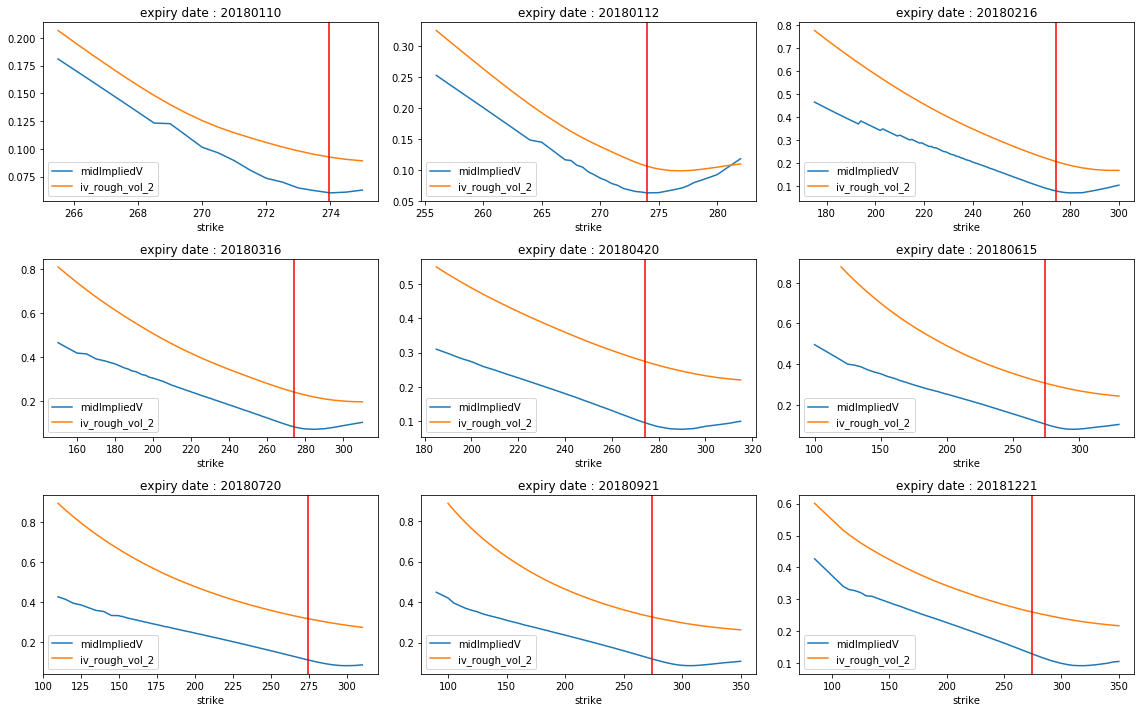

In [33]:
plot_iv_skew(df_iv_groupBy)

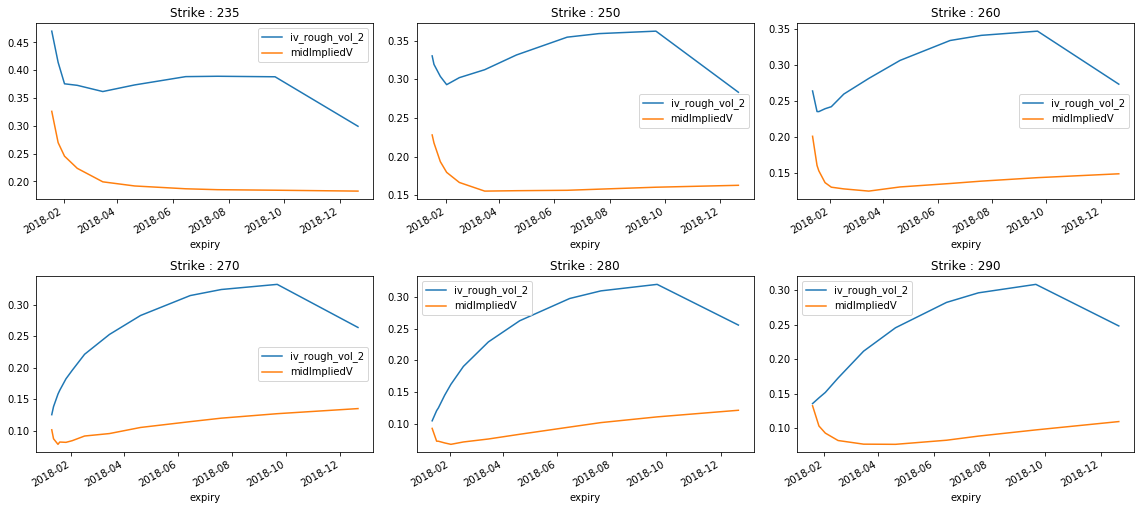

In [36]:
plot_term_struct(df_iv_groupBy)